# Density loss
* $C(t)$: *C. glutamicum* (Coryne) population

$$
\frac{dC}{dt} = \mu_C   \cdot C \cdot  - \theta \cdot C^2
$$


* density loss

$$
\theta = \frac{\mu C -   \frac{dC}{dT}}{C^2}
$$

* new population growth rate

$$
\mu = \frac{\frac{dC}{dT}-\bar{\theta}\cdot C^2 }{ C }
$$

**Parameter :**

* $\mu$: growth rate
* $\theta$: density loss
* $C$: Coryne population 
* $\frac{dC}{dT}$: rate of change of $C$ over time
* $a_c$: affinity coefficient
* $\bar{\theta}$: average density loss










# model 2(population dynamics)


* $E(t)$: *E. coli* population
* $C(t)$: *C. glutamicum* (Coryne) population

$$
\frac{dE}{dt} = \mu_E \cdot a_E  \cdot E - \delta_E \cdot E
$$

$$
\frac{dC}{dt} = \mu_C \cdot a_C  \cdot C \cdot - \theta \cdot C^2 
$$

In [14]:
import numpy as np
import pandas as pd
from mxlpy import Model, scan, plot, Simulator

## Define model

   C_old  C_new   mu     dC/dT     theta
0      5     50  0.4  3.214286  0.006714
1     10     60  0.3  3.571429  0.004008
2     20     70  0.2  3.571429  0.002128
3    100    115  0.1  1.071429  0.000789

Average theta: 0.0034


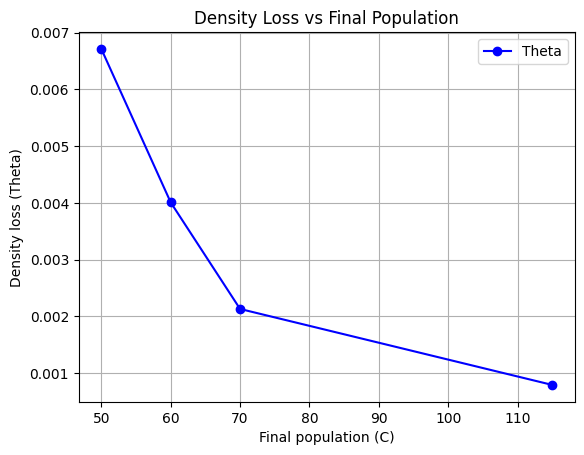

In [15]:

# Time interval
dT = 14


# Reaction-like functions
def dC_dT(C_old: float, C_new: float, dT: float) -> float:
    return (C_new - C_old) / dT


def theta(mu: float, C: float, dC_dt: float) -> float:
    return (mu * C - dC_dt) / (C * C)


# Structured model builder
def get_density_loss_model() -> dict:
    return {
        "C_old": np.array([5, 10, 20, 100]),
        "C_new": np.array([50, 60, 70, 115]),
        "mu": np.array([0.4, 0.3, 0.2, 0.1]),
        "dT": dT,
    }


# Scenario runner
def run_model(model: dict) -> pd.DataFrame:
    C_old = model["C_old"]
    C_new = model["C_new"]
    mu = model["mu"]
    dT = model["dT"]

    dC_dt_vals = np.array([dC_dT(c_old, c_new, dT) for c_old, c_new in zip(C_old, C_new)])
    theta_vals = np.array([theta(m, c, dc) for m, c, dc in zip(mu, C_new, dC_dt_vals)])

    return pd.DataFrame({
        "C_old": C_old,
        "C_new": C_new,
        "mu": mu,
        "dC/dT": dC_dt_vals,
        "theta": theta_vals,
    })


# Build and run
model = get_density_loss_model()
results = run_model(model)

# Print summary
print(results)
print(f"\nAverage theta: {results['theta'].mean():.4f}")

# Plot
plt.plot(results["C_new"], results["theta"], marker="o", color="blue")
plt.xlabel("Final population (C)")
plt.ylabel("Density loss (Theta)")
plt.title("Density Loss vs Final Population")
plt.legend(["Theta"])
plt.grid(True)
plt.show()


In [11]:
from mxlpy.types import unwrap


def v0(mu_e: float, a_e: float, e: float) -> float:
    return mu_e * a_e * e


def v1(delta_e: float, e: float) -> float:
    return delta_e * e


def v2(mu_c: float, a_c: float, c: float) -> float:
    return mu_c * a_c * c


def v3(v2: float, theta: float, c: float) -> float:
    return c * theta * c


def get_model_2() -> Model:
    return (
        Model()
        .add_variables({"E": 5.0, "C": 5.0})
        .add_parameters(
            {
                "mu_e": 0.4,
                "mu_c": 0.3,
                "a_e": 0.1,
                "a_c": 0.1,
                "delta_e": 0.1,
                "theta": 0.0034,
            }
        )
        .add_reaction("v0", v0, args=["mu_e", "a_e", "E"], stoichiometry={"E": 1})
        .add_reaction("v1", v1, args=["delta_e", "E"], stoichiometry={"E": -1})
        .add_reaction("v2", v2, args=["mu_c", "a_c", "C"], stoichiometry={"C": 1})
        .add_reaction("v3", v3, args=["v2", "theta", "C"], stoichiometry={"C": -1})
    )


scenarios = pd.DataFrame(
    [
        {"a_e": 1.0, "a_c": 0.3},
        {"a_e": 0.9, "a_c": 0.4},
        {"a_e": 0.8, "a_c": 0.5},
        {"a_e": 0.7, "a_c": 0.6},
        {"a_e": 0.4, "a_c": 0.8},
        {"a_e": 0.3, "a_c": 1.0},
    ]
)


## Run scan (v1)

Here we use an explicit for loop to do the simulation.  
This should be easier to read for the first time, but has a few disadvantages

- the for loop is run sequentially, so you don't get any speed benefits from having more than 1 CPU core
- if you use `simulate` instead of `simulate_time_course` it's easy to get mismatching time points, which make comparisons harder
- you don't have access to previous simulation results (easy to fix though)
- more verbose



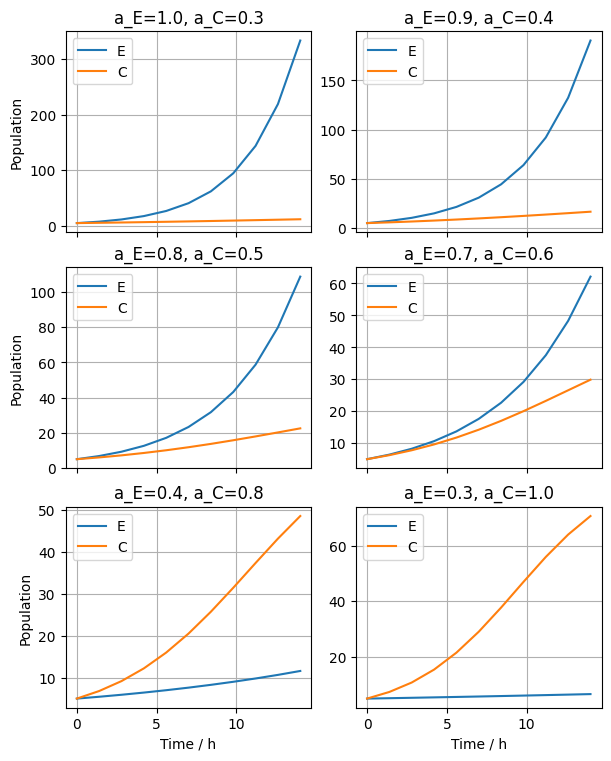

In [13]:
fig, axs = plot.grid_layout(len(scenarios))
for ax, (_, pars) in zip(axs, scenarios.iterrows()):
    res = unwrap(
        Simulator(get_model_2())
        .update_parameters(pars.to_dict())
        .simulate_time_course(np.linspace(0, 14, 11))
        .get_result()
    )
    plot.lines(
        res.variables,
        xlabel="",
        ylabel="",
        ax=ax,
    )
    ax.set_title("a_E={}, a_C={}".format(*pars))
plot.grid_labels(axs, xlabel="Time / h", ylabel="Population")


## Run scan (v2)

To run this kind (and other kinds of scans for that matter), you can also use the functions supplied by the `scan` module.

All these routines run in parallel automatically, and offer the possibility to cache long calculations using the `cache` argument.

You can obtain the variables and fluxes with `.variables` and `.fluxes` respectively and check the parameters / initial conditions etc you put into the scan with `.to_scan`. 

You can also get aggregates over time or run (not super useful in your case using)

```python
res.get_agg_per_time("mean")
res.get_agg_per_run("mean")
```

Challenges here:

- You have to learn how to use a `pandas.MultiIndex` because the resulting dataframe will look something like this. But that's a nice thing to learn in general, it will pop up in all kinds of data analysis down the road
  

|              (n, time) |        E |       C |
|:-----------------------|---------:|--------:|
| (0, 0.0)               |  5       | 5       |
| (0, 1.4)               |  7.60981 | 5.66761 |
| (0, 2.8)               | 11.5818  | 6.42378 |
| (0, 4.199999999999999) | 17.6271  | 7.28009 |
| (0, 5.6)               | 26.8278  | 8.24962 |

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 533.55it/s]


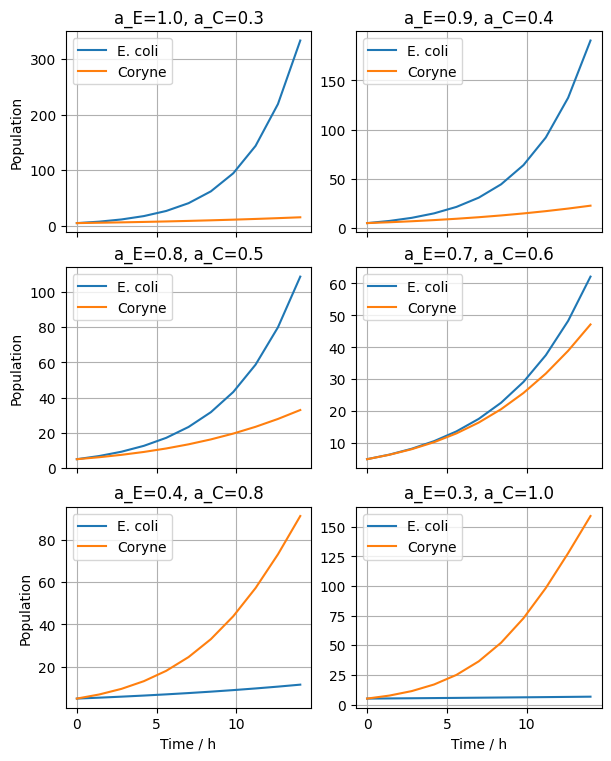

In [8]:
res = scan.time_course(
    get_model_2(),
    to_scan=scenarios,
    time_points=np.linspace(0, 14, 11),
)

fig, axs = plot.grid_layout(len(scenarios))
for ax, (i, df) in zip(axs, res.variables.groupby(level=0)):
    plot.lines(
        df.droplevel(0).rename(columns={"E": "E. coli", "C": "Coryne"}),
        ax=ax,
        xlabel="",
        ylabel="",
    )
    ax.set_title("a_E={}, a_C={}".format(*res.to_scan.loc[i]))
plot.grid_labels(axs, xlabel="Time / h", ylabel="Population")
